<a href="https://colab.research.google.com/github/demirkeseny/power_of_ridge_regression/blob/main/Power_of_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explanatory Data Analysis

A machine learning model can get more powerful only when the data used to train and validate it becomes a better representative of the real world. That's why data cleaning and feature selection are key steps of any data science flow. In this notebook, there is the detailed explanation of the explanatory data analysis steps before feeding the data to a regression model. \\
Refer to this [link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt) for data dictionary!

In [1]:
# importing necessary libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from vega_datasets import data
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# first view on our data
housing_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/housing.csv')

In [3]:
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
housing_data.shape

(1460, 81)

In [5]:
# checking the column types 
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Fill the missing values:

In [6]:
# checking the number of missing data in columns that contain missing data
null_df = pd.DataFrame(housing_data.isnull().sum())
null_df[null_df[0]!=0]

,0
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [7]:
housing_data.LotFrontage = housing_data.LotFrontage.fillna(0)
housing_data.MasVnrType = housing_data.MasVnrType.fillna('None')
housing_data.MasVnrArea = housing_data.MasVnrArea.fillna(0)
housing_data.BsmtQual = housing_data.BsmtQual.fillna('NA')
housing_data.BsmtCond = housing_data.BsmtCond.fillna('NA')
housing_data.BsmtExposure = housing_data.BsmtExposure.fillna('NA')
housing_data.Electrical = housing_data.Electrical.fillna('Mix')
housing_data.GarageType = housing_data.GarageType.fillna('NA')
housing_data.Fence = housing_data.Fence.fillna('NA')
housing_data.PoolQC = housing_data.PoolQC.fillna('NA')
housing_data.PoolQC = housing_data.PoolQC.replace('NaN','NA')
housing_data.MiscFeature = housing_data.MiscFeature.fillna('NA')
housing_data.GarageCond = housing_data.GarageCond.fillna('NA')
housing_data.GarageQual = housing_data.GarageQual.fillna('NA')
housing_data.BsmtFinType1 = housing_data.BsmtFinType1.fillna('NA')
housing_data.BsmtFinType2 = housing_data.BsmtFinType2.fillna('NA')
housing_data.FireplaceQu = housing_data.FireplaceQu.fillna('NA')
housing_data.GarageFinish = housing_data.GarageFinish.fillna('NA')
housing_data.Alley = housing_data.Alley.fillna('NA')

Now decide what to do with all of the columns. There are categorical and numerical. For categorical, create dummies. For categorical there are columns like `ExterQual` which has an order like Excellent, Good, .. but they are represented with strings rather than numbers. Convert them to numbers:

In [8]:
# converting every ordinal categorical value to numeric representations.
# since there are no nulls we can end the if loop with 1. 
housing_data.ExterQual.map(lambda x: 4 if x=="Ex" else (3 if x == 'Gd' else (2 if x == 'TA' else 1))).value_counts()

2    906
3    488
4     52
1     14
Name: ExterQual, dtype: int64

In [9]:
# since above numbers are right, it means that we did the map function right. Let's make it inplace. 
housing_data.ExterQual = housing_data.ExterQual.map(lambda x: 4 if x=="Ex" else (3 if x == 'Gd' else (2 if x == 'TA' else 1)))

In [10]:
housing_data.ExterCond = housing_data.ExterCond.map(lambda x: 5 if x=="Ex" else (4 if x == 'Gd' else (3 if x == 'TA' else (2 if x == 'Fa' else 1))))

In [11]:
bsmt_zip = {'Ex':6,
            'Gd':5,
            'TA':4,
            'Fa':3,
            'Po':2,
            'NA':1}

In [12]:
# do similar for the BsmtCond, BsmtExposure column
housing_data.BsmtQual = housing_data.BsmtQual.map(bsmt_zip)
housing_data.BsmtCond = housing_data.BsmtCond.map(bsmt_zip)

In [13]:
bsmt_zip2 = {'Gd':5,
            'Av':4,
            'Mn':3,
            'No':2,
            'NA':1}

In [14]:
housing_data.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
NA     38
Name: BsmtExposure, dtype: int64

In [15]:
# do similar for the BsmtCond, BsmtExposure column
housing_data.BsmtExposure = housing_data.BsmtExposure.map(bsmt_zip2)

In [16]:
kitchen_zip = {'Ex':5,
            'Gd':4,
            'TA':3,
            'Fa':2,
            'Po':1}
housing_data.KitchenQual = housing_data.KitchenQual.map(kitchen_zip)

In [17]:
pool_zip = {'Ex':5,
            'Gd':4,
            'TA':3,
            'Fa':2,
            'NA':1}
housing_data.PoolQC = housing_data.PoolQC.map(pool_zip)

For the year data, I will convert it to three bins: new mid and old. Houses earlier than 1978 will be labeled as old. 1978 is picked because that is the year where it was decided that lead in wall paintings are prohibited. Since I have experienced the price change of buildings built earlier than 1978 I decided 1978 to be the threshold value. 

In [18]:
housing_data.YearBuilt = housing_data.YearBuilt.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [19]:
housing_data.YrSold = housing_data.YrSold.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [20]:
housing_data.YearRemodAdd = housing_data.YearRemodAdd.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [21]:
housing_data.drop(columns=['Id'], inplace=True)

In [22]:
housing_data.MSSubClass = housing_data.MSSubClass.astype(str)

In [23]:
bsmt_fin_zip = {'GLQ':6,
                'ALQ':5,
                'BLQ':4,
                'Rec':3,
                'LwQ':2,
                'Unf':1,
                'NA':0}
housing_data.BsmtFinType1 = housing_data.BsmtFinType1.map(bsmt_fin_zip)

In [24]:
housing_data.BsmtFinType2 = housing_data.BsmtFinType2.map(bsmt_fin_zip)

In [25]:
housing_data.HeatingQC = housing_data.HeatingQC.map(kitchen_zip)

In [26]:
function_zip = {'Typ':7,
                'Min1':6,
                'Min2':5,
                'Mod':4,
                'Maj1':3,
                'Maj2':2,
                'Sev':1,
                'Sal':0}
housing_data.Functional = housing_data.Functional.map(function_zip)

In [27]:
housing_data.GarageYrBlt = housing_data.GarageYrBlt.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [28]:
garage_fin_zip = {'Fin':3,
                'RFn':2,
                'Unf':1,
                'NA':0}
housing_data.GarageFinish = housing_data.GarageFinish.map(garage_fin_zip)

In [29]:
housing_data.GarageQual = housing_data.GarageQual.map(bsmt_zip)
housing_data.GarageCond = housing_data.GarageCond.map(bsmt_zip)

In [30]:
pave_zip = {'Y':3,
                'P':2,
                'N':1}
housing_data.PavedDrive = housing_data.PavedDrive.map(pave_zip)

In [31]:
fence_zip = {'GdPrv':4,
                'MnPrv':3,
                'GdWo':2,
                'MnWw':1,
                'NA':0}
housing_data.Fence = housing_data.Fence.map(fence_zip)

In [32]:
alley_zip = {'Pave':2,
             'Grvl':1,
             'NA':0}
housing_data.Alley = housing_data.Alley.map(alley_zip)

In [33]:
housing_data.FireplaceQu = housing_data.FireplaceQu.map(bsmt_zip)

In [34]:
pave_zip = {'Pave':2,
             'Grvl':1}
housing_data.Street = housing_data.Street.map(pave_zip)

In [35]:
slope_zip = {'Gtl':2,
             'Mod':1,
             'Sev':0}
housing_data.LandSlope = housing_data.LandSlope.map(slope_zip)

In [36]:
housing_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,2,0,Reg,Lvl,AllPub,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,new,new,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,3,PConc,5,4,2,6,706,1,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,1,Attchd,new,2,2,548,4,4,3,0,61,0,0,0,0,1,0,NA,0,2,new,WD,Normal,208500
1,20,RL,80.0,9600,2,0,Reg,Lvl,AllPub,FR2,2,Veenker,Feedr,Norm,1Fam,1Story,6,8,old,old,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,3,CBlock,5,4,5,5,978,1,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,4,Attchd,old,2,2,460,4,4,3,298,0,0,0,0,0,1,0,NA,0,5,new,WD,Normal,181500
2,60,RL,68.0,11250,2,0,IR1,Lvl,AllPub,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,new,new,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,3,PConc,5,4,3,6,486,1,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,4,Attchd,new,2,2,608,4,4,3,0,42,0,0,0,0,1,0,NA,0,9,new,WD,Normal,223500
3,70,RL,60.0,9550,2,0,IR1,Lvl,AllPub,Corner,2,Crawfor,Norm,Norm,1Fam,2Story,7,5,old,old,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,3,BrkTil,4,5,2,5,216,1,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,5,Detchd,mid,1,3,642,4,4,3,0,35,272,0,0,0,1,0,NA,0,2,new,WD,Abnorml,140000
4,60,RL,84.0,14260,2,0,IR1,Lvl,AllPub,FR2,2,NoRidge,Norm,Norm,1Fam,2Story,8,5,new,new,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,3,PConc,5,4,4,6,655,1,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,7,1,4,Attchd,new,2,3,836,4,4,3,192,84,0,0,0,0,1,0,NA,0,12,new,WD,Normal,250000


All the ordinal categorical values are replaced with numerical representations. Our data doesn't have ordinal categorical values anymore. There are also no missing data. \\
The next step is to get rid of all the columns that have the object type. They need to be replaced with dummy columns so that we can feed only numeric data to our model. 

In [37]:
df_types = pd.DataFrame(housing_data.dtypes).reset_index()
string_columns = df_types[df_types[0]=='object']['index']
non_string_columns = df_types[df_types[0]!='object']['index']

In [38]:
# all the non-string columns
housing_data[non_string_columns].head()

,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,SalePrice
0,65.0,8450,2,0,2,7,5,196.0,3,3,5,4,2,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,1,2,2,548,4,4,3,0,61,0,0,0,0,1,0,0,2,208500
1,80.0,9600,2,0,2,6,8,0.0,2,3,5,4,5,5,978,1,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,4,2,2,460,4,4,3,298,0,0,0,0,0,1,0,0,5,181500
2,68.0,11250,2,0,2,7,5,162.0,3,3,5,4,3,6,486,1,0,434,920,5,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,4,2,2,608,4,4,3,0,42,0,0,0,0,1,0,0,9,223500
3,60.0,9550,2,0,2,7,5,0.0,2,3,4,5,2,5,216,1,0,540,756,4,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,5,1,3,642,4,4,3,0,35,272,0,0,0,1,0,0,2,140000
4,84.0,14260,2,0,2,8,5,350.0,3,3,5,4,4,6,655,1,0,490,1145,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,7,1,4,2,3,836,4,4,3,192,84,0,0,0,0,1,0,0,12,250000


In [39]:
dummy_df = pd.get_dummies(housing_data[string_columns])

In [40]:
# creating the ultimate dataframe where we have no categorical values
df = pd.concat([dummy_df,housing_data[non_string_columns]], axis=1)

In [41]:
# no object typed columns left
df.dtypes.value_counts()

uint8      195
int64       50
float64      2
dtype: int64

In [42]:
df.shape

(1460, 247)

In [43]:
# number of missing data
df.isnull().sum().sum()

0

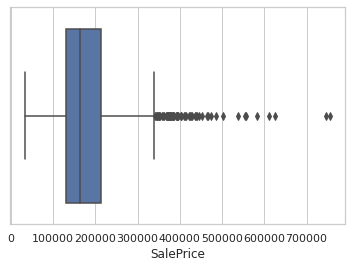

In [44]:
# check the outliers in target value
sns.set_theme(style="whitegrid")
sns.boxplot(x=df['SalePrice']);

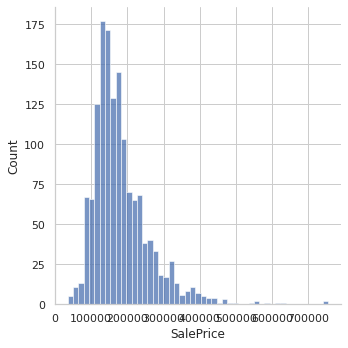

In [45]:
sns.displot(df['SalePrice']);

In the above two charts, we see that SalePrice: \\

*   Has multiple outliers
*   Has a positive skewness \\

At this point, I decide not to tackle the outliers. I will leave them as they are. They might be handy if we see a similar data point in my testing dataset. 



# Preprocessing

In [46]:
df.shape

(1460, 247)

Right now there are almost 250 predictors and 1 target variable. Here we need to decrease the number of predictors. There are 2 options. \\
1. Manually deleting the fields with less correlation to the target.
2. Using a regularization technique to pick only the most useful predictors. 


Since 250 predictors cannot be easily selected on a visualization, I first eliminate some manually then use Ridge to determine the useful predictors. I want to use Ridge because I already eliminated the unrelated predictors. I don't want to use a harsh regulizer like Lasso at this point.

In [47]:
# find the most correlated columns:
df_corr = abs(df.corr()).sort_values(by='SalePrice', ascending=False)[['SalePrice']]
df_corr[df_corr['SalePrice']>0.4]

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
ExterQual,0.682639
KitchenQual,0.659600
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
BsmtQual,0.585207


In [48]:
df_small = df[df_corr[df_corr['SalePrice']>0.4].index.tolist()]
df_small.shape

(1460, 24)

Now we decreased the number of predictors from 247 to 24. 

Before we do any further move I will split my data. The reason why I do that now is from this point on, it is the training phase. Any test data that I will introduce during modelling or premodelling, will create a bias in my evaluation metrics. 

In [49]:
df_small.reset_index(inplace=True,drop=True)

In [50]:
X = df_small.drop(columns=['SalePrice'])
y = df_small['SalePrice']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [52]:
X_train.head()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,YearBuilt_old,GarageFinish,TotRmsAbvGrd,FireplaceQu,GarageYrBlt_old,Foundation_PConc,MasVnrArea,Fireplaces,YearBuilt_new,YearRemodAdd_old,GarageYrBlt_new,HeatingQC,Neighborhood_NridgHt
1023,7,1504,3,4,2,437,1346,1504,5,2,0,3,7,5,0,1,14.0,1,1,0,1,5,0
810,6,1309,2,4,2,484,1040,1309,4,1,1,2,5,3,1,0,99.0,1,0,0,0,2,0
1384,6,1258,2,3,1,280,560,698,4,1,1,1,6,1,1,0,0.0,0,0,1,0,3,0
626,5,1422,2,3,1,286,978,1422,4,1,1,2,6,4,1,0,0.0,1,0,1,0,3,0
813,6,1442,2,3,1,301,1442,1442,4,1,1,2,7,1,1,0,243.0,0,0,1,0,4,0


Since I will be utilizing a linear regression model, I need to meet its assumptions.

1. Linearity: a predictor and the target value have a linear relationship
2. Independence of error: no dependence between errors
3. Normality: the errors are normally distributed
4. Equality of variance: error values have a similar variance no matter what the value of the predictor becomes.
5. Independence of predictors: no multicollinearity!

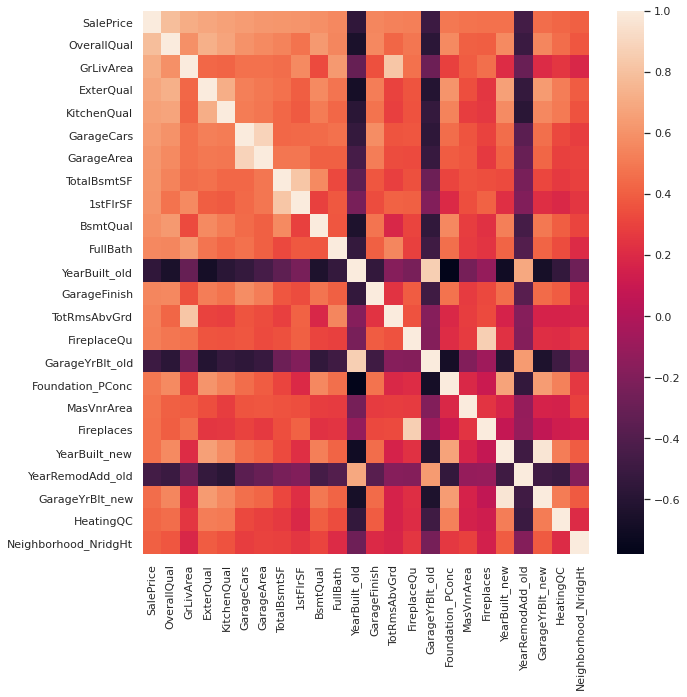

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_small.abs().corr())

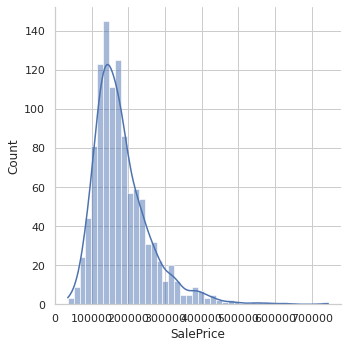

In [54]:
sns.displot(y_train, kde=True);

The above distribution doesn't seem like normal. We need transformation.

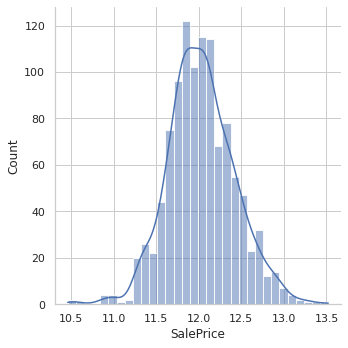

In [55]:
sns.displot(np.log(y_train), kde=True);

Now the price looks like normally distributed. Let's double check that with a probability plot.

In [56]:
y_train = np.log(y_train)
y_test = np.log(y_test)

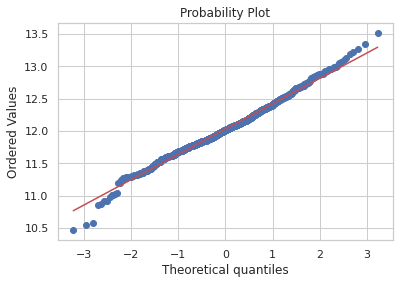

In [57]:
stats.probplot(y_train, plot=plt);

I will do the same process for the other predictors which are not bound to a certain range: \\
- GrLivArea
- GarageArea
- TotalBsmtSF
- 1stFlrSF
- MasVnrArea \\
We cannot transform the GarageArea since there are many places without a garage. Log transform cannot applied on values with zero. So we might assign them 1 sf instead of 0. Then we can do a log transform.

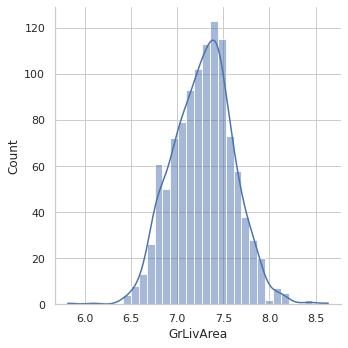

In [58]:
sns.displot(np.log(X_train['GrLivArea']), kde=True);

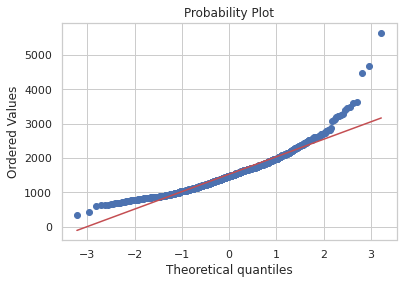

In [59]:
stats.probplot(X_train['GrLivArea'], plot=plt);

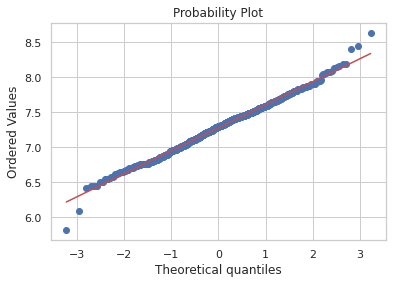

In [60]:
stats.probplot(np.log(X_train['GrLivArea']), plot=plt);

In [61]:
# GrLivArea will be transformed
X_train['GrLivArea'] = np.log(X_train['GrLivArea'])
X_test['GrLivArea'] = np.log(X_test['GrLivArea'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
X_train['GarageArea'] = X_train['GarageArea'].map(lambda x: 1 if x==0 else x);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


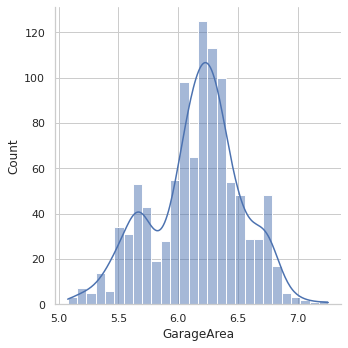

In [63]:
sns.displot(np.log(X_train[X_train['GarageArea']>1]['GarageArea']), kde=True);

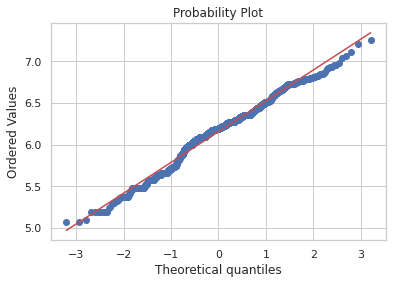

In [64]:
stats.probplot(np.log(X_train[X_train['GarageArea']>1]['GarageArea']), plot=plt);

In [65]:
# GarageArea will be transformed
X_test['GarageArea'] = X_test['GarageArea'].map(lambda x: 1 if x==0 else x);
X_train['GarageArea'] = np.log(X_train['GarageArea'])
X_test['GarageArea'] = np.log(X_test['GarageArea'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [66]:
X_train['TotalBsmtSF'] = X_train['TotalBsmtSF'].map(lambda x: 1 if x==0 else x);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


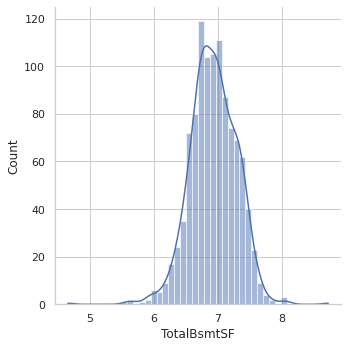

In [67]:
sns.displot(np.log(X_train[X_train['TotalBsmtSF']>1]['TotalBsmtSF']), kde=True);

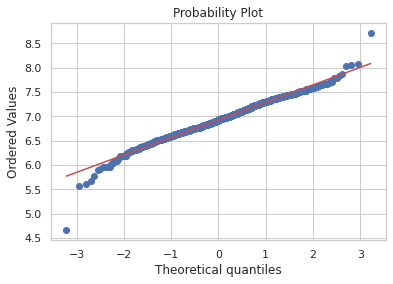

In [68]:
stats.probplot(np.log(X_train[X_train['TotalBsmtSF']>1]['TotalBsmtSF']), plot=plt);

In [69]:
# TotalBsmtSF will be transformed
X_test['TotalBsmtSF'] = X_test['TotalBsmtSF'].map(lambda x: 1 if x==0 else x);
X_train['TotalBsmtSF'] = np.log(X_train['TotalBsmtSF'])
X_test['TotalBsmtSF'] = np.log(X_test['TotalBsmtSF'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

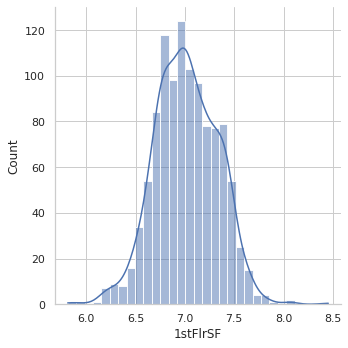

In [70]:
sns.displot(np.log(X_train['1stFlrSF']), kde=True);

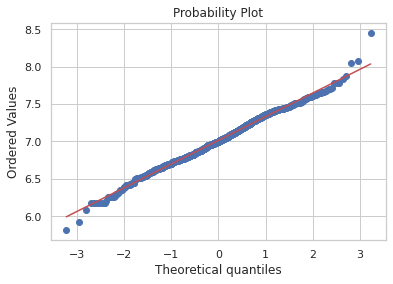

In [71]:
stats.probplot(np.log(X_train['1stFlrSF']), plot=plt);

In [72]:
# GrLivArea will be transformed
X_train['1stFlrSF'] = np.log(X_train['1stFlrSF'])
X_test['1stFlrSF'] = np.log(X_test['1stFlrSF'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


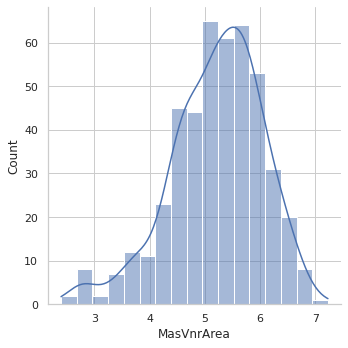

In [73]:
sns.displot(np.log(X_train[X_train['MasVnrArea']>1]['MasVnrArea']), kde=True);

In [74]:
# MasVnrArea will be transformed
X_train['MasVnrArea'] = X_train['MasVnrArea'].map(lambda x: 1 if x==0 else x);
X_test['MasVnrArea'] = X_test['MasVnrArea'].map(lambda x: 1 if x==0 else x);
X_train['MasVnrArea'] = np.log(X_train['MasVnrArea'])
X_test['MasVnrArea'] = np.log(X_test['MasVnrArea'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Now we can start with standardizing the data. This is helpful to bring all the data to the same scale.

In [75]:
from sklearn.preprocessing import StandardScaler
# Instantiate Standard Scaler.
ss = StandardScaler()
# fit 
Z_train = ss.fit_transform(X_train)
# transform the df
Z_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)

In [76]:
Z_train.head()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,YearBuilt_old,GarageFinish,TotRmsAbvGrd,FireplaceQu,GarageYrBlt_old,Foundation_PConc,MasVnrArea,Fireplaces,YearBuilt_new,YearRemodAdd_old,GarageYrBlt_new,HeatingQC,Neighborhood_NridgHt
0,0.637073,0.110952,1.057489,0.743356,0.293831,0.174967,0.396382,0.949769,0.578106,0.772872,-1.161803,1.429748,0.268177,1.193319,-1.021230,1.107073,0.176570,0.591298,1.635389,-0.799513,1.591307,0.890733,-0.236496
1,-0.094926,-0.310564,-0.683790,0.743356,0.293831,0.246625,0.168594,0.511752,-0.562482,-1.062909,0.860731,0.305861,-0.963076,0.088301,0.979211,-0.903283,0.921441,0.591298,-0.611475,-0.799513,-0.628414,-2.222095,-0.236496
2,-0.094926,-0.431194,-0.683790,-0.761219,-1.069494,-0.137294,-0.378133,-1.471653,-0.562482,-1.062909,0.860731,-0.818025,-0.347450,-1.016718,0.979211,-0.903283,-0.828387,-0.961392,-0.611475,1.250761,-0.628414,-1.184486,-0.236496
3,-0.826925,-0.059227,-0.683790,-0.761219,-1.069494,-0.122421,0.114307,0.772929,-0.562482,-1.062909,0.860731,0.305861,-0.347450,0.640810,0.979211,-0.903283,-0.828387,0.591298,-0.611475,1.250761,-0.628414,-1.184486,-0.236496
4,-0.094926,-0.016831,-0.683790,-0.761219,-1.069494,-0.086562,0.457228,0.816983,-0.562482,-1.062909,0.860731,0.305861,0.268177,-1.016718,0.979211,-0.903283,1.263379,-0.961392,-0.611475,1.250761,-0.628414,-0.146876,-0.236496


# Modeling

Since our data is ready, we can start with the modelling phase.

In [77]:
from sklearn.linear_model import Ridge

First, I will be visualizing the ridge and its impact on the regression coefficients:

In [78]:
def ridge_coefs(X, y, alphas):
    
    # list of coefficients:
    coefs = []
    
    # initiate the model
    ridge_reg = Ridge()
    
    # iterate through the alphas fed into the function:
    for a in alphas:
        
        # reinitiate with the new alpha:
        ridge_reg.set_params(alpha=a)
        
        # refit the model on the provided X, y
        ridge_reg.fit(X, y)
        
        # print the coefficient list
        coefs.append(ridge_reg.coef_)
        
    return coefs
  # this snippet is taken from an online source

In [79]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. It is base 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(Z_train, y_train, r_alphas)

In [80]:
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,5)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coefficients\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(list(range(1, len(feature_names)+1)), coefs[-1], align='center', color=colors)
    ax2.set_xticks(list(range(1, len(feature_names)+1)))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefficients\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()
  # this snippet is taken from an online source

In [81]:
from ipywidgets import *
from IPython.display import display

def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, X.columns, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.1,5,0.2))
print("this snippet is taken from an online source")

interactive(children=(FloatSlider(value=0.1, description='log_of_alpha', max=5.0, min=0.1, step=0.2), Output()…

this snippet is taken from an online source


Thanks to the visualization, we can understand the relationship between the alpha (strength of the regularization coefficient) and coefficients. But how to pick the best alpha? 
The answer can be found by trial and error. In this case, we will train different models on the training set and pick the model with the biggest alpha.  

In [82]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV

In [83]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)
# Generates 200 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2')

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(Z_train, y_train)

In [84]:
# Here is the optimal value of alpha
ridge_optimal_alpha = ridge_model.alpha_
ridge_optimal_alpha

46.4158883361278

In [85]:
# transform the df
Z_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

In [86]:
# Instantiate model.
ridge_opt = Ridge(alpha=ridge_optimal_alpha)

# Fit model.
ridge_opt.fit(Z_train, y_train)

# Generate predictions
ridge_opt_preds = ridge_opt.predict(Z_test)
ridge_opt_preds_train = ridge_opt.predict(Z_train)

# Evaluate model.
print(r2_score(y_test, ridge_opt_preds))
print(r2_score(y_train, ridge_opt_preds_train))

0.8599606350326111
0.8391973181594015


So the conclusion, the R squared value for the test data was 0.86. This is higher than the score from the training dataset which proves that in a dataset that might highly overfit, we achieved to fit our model to the signal rather than the noise. 